In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import cv2
import datetime, os
import string
import glob
import shutil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorboard
from tensorboard.plugins.hparams import api as hp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, save_model



In [2]:
## Set image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.3,  
    horizontal_flip=True,
    vertical_flip= True ,
    fill_mode='nearest' 
)

# No Augmentatin applied for both Validation and Testing Datasets
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Load images from directories
train_generator = train_datagen.flow_from_directory(
    'D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Teeth Classification/Dataset/Teeth_Dataset/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # 'categorical' for multi-class classification, one-hot encoded vectors
)

val_generator = val_test_datagen.flow_from_directory(
    'D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Teeth Classification/Dataset/Teeth_Dataset/Validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Teeth Classification/Dataset/Teeth_Dataset/Testing',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [3]:
train_step=train_generator.n//train_generator.batch_size
test_step=test_generator.n//test_generator.batch_size
valid_step =val_generator.n//val_generator.batch_size

In [4]:
# Wrapping our model and training in a function with the specified hyperparameters


# Building the model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height,img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(7, activation='softmax')
])
model.summary()
   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [5]:
 
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 10,
    verbose = 0, 
    restore_best_weights = True
    )



In [6]:
model.fit(train_generator,
          steps_per_epoch=train_step,
          epochs=100, 
          validation_data=val_generator,
          validation_steps=valid_step,
          callbacks=[ early_stopping]
            )



Epoch 1/100
96/96 [==============================] - 43s 427ms/step - loss: 1.9075 - accuracy: 0.2167 - val_loss: 1.8264 - val_accuracy: 0.2881
Epoch 2/100
96/96 [==============================] - 44s 457ms/step - loss: 1.7856 - accuracy: 0.2894 - val_loss: 1.6292 - val_accuracy: 0.3477
Epoch 3/100
96/96 [==============================] - 42s 434ms/step - loss: 1.7065 - accuracy: 0.3221 - val_loss: 1.6911 - val_accuracy: 0.3389
Epoch 4/100
96/96 [==============================] - 40s 411ms/step - loss: 1.6399 - accuracy: 0.3601 - val_loss: 1.6036 - val_accuracy: 0.3496
Epoch 5/100
96/96 [==============================] - 41s 422ms/step - loss: 1.6164 - accuracy: 0.3637 - val_loss: 1.5299 - val_accuracy: 0.4072
Epoch 6/100
96/96 [==============================] - 41s 430ms/step - loss: 1.5388 - accuracy: 0.4029 - val_loss: 1.4154 - val_accuracy: 0.4678
Epoch 7/100
96/96 [==============================] - 40s 411ms/step - loss: 1.5209 - accuracy: 0.4039 - val_loss: 1.3648 - val_accuracy:

### Saving Model

In [7]:
save_model = model.save('D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Teeth Classification/Model/Teeth.keras')

In [8]:
# The loaded model is used for inference, evaluation, or further training
new_model = keras.models.load_model('D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Teeth Classification/Model/Teeth.keras')

### Evaluation Process

In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = new_model.evaluate(test_generator, steps=test_step)
print("Test accuracy:", test_accuracy)

32/32 [==============================] - 2s 49ms/step - loss: 0.0645 - accuracy: 0.9844
Test accuracy: 0.984375


In [10]:
test_generator.samples , test_generator.batch_size

(1028, 32)

In [11]:

# Get all the test samples and labels
test_samples = []
test_labels = []
num_batches = test_generator.samples // test_generator.batch_size  # Total number of batches
   

In [12]:
for _ in range(num_batches):
    batch_samples, batch_labels = test_generator.next()
    test_samples.append(batch_samples)
    test_labels.append(batch_labels)

In [13]:
# Concatenate the samples and labels from all batches
test_samples = np.concatenate(test_samples)
test_labels = np.concatenate(test_labels)

In [14]:
# Generate predictions on the test samples
test_predictions = new_model.predict(test_samples)

32/32 [==============================] - 1s 42ms/step


In [15]:
# Calculate the predicted class indices
predicted_class_indices = np.argmax(test_predictions, axis=1)

# Calculate the true class indices
true_class_indices = np.argmax(test_labels, axis=1)

In [16]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(true_class_indices, predicted_class_indices)

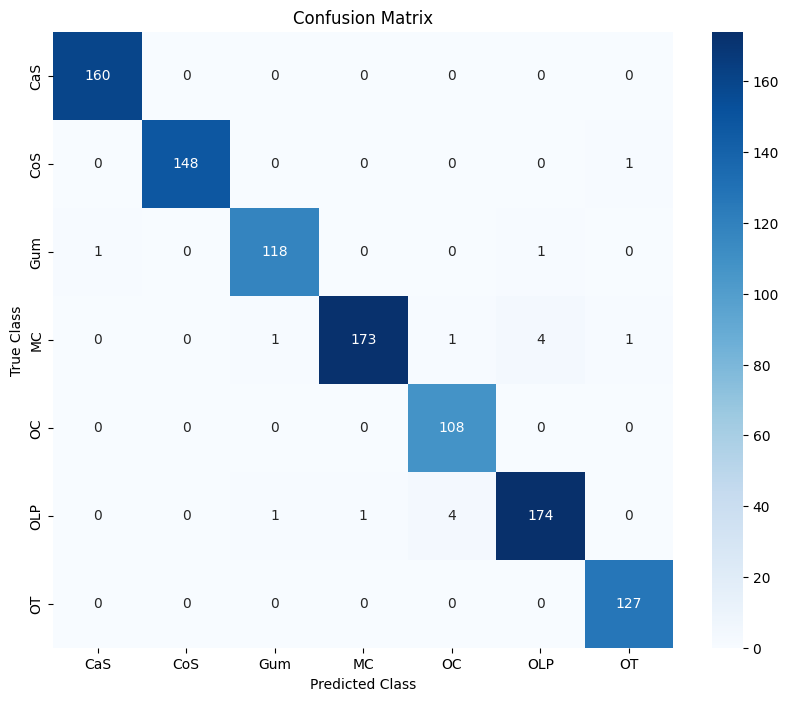

In [18]:
classes = ['CaS','CoS','Gum','MC','OC','OLP','OT']
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

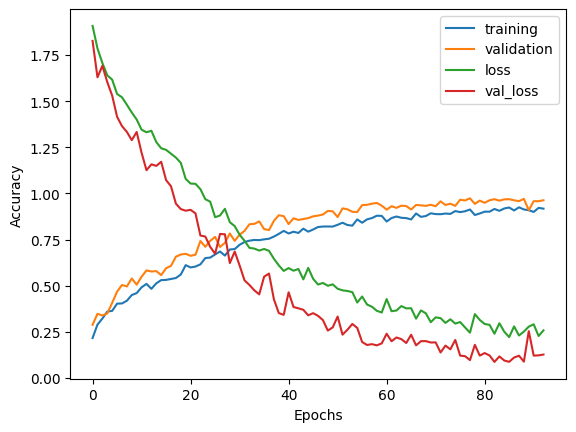

In [19]:
# Plotting the training and validation accuracy and loss
plt.plot(model.history.history['accuracy'],label='training')
plt.plot(model.history.history['val_accuracy'],label='validation')
plt.plot(model.history.history["loss"],label='loss')
plt.plot(model.history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

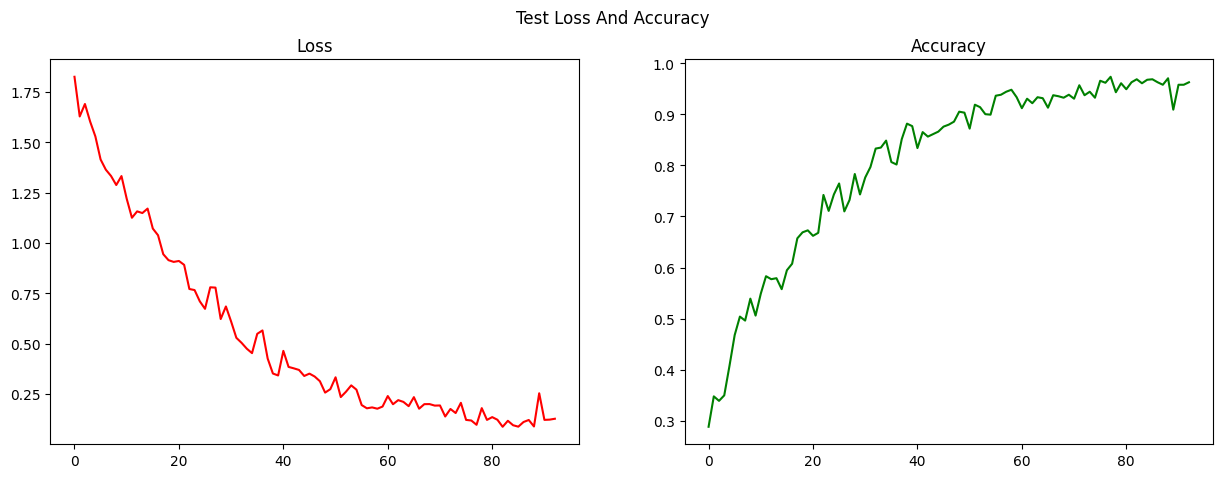

In [20]:
# Plotting the test loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Test Loss And Accuracy')

sns.lineplot(ax=ax[0], data=model.history.history['val_loss'], color='r')
ax[0].set_title('Loss')

sns.lineplot(ax=ax[1], data=model.history.history['val_accuracy'], color='g')
ax[1].set_title('Accuracy')

plt.show()

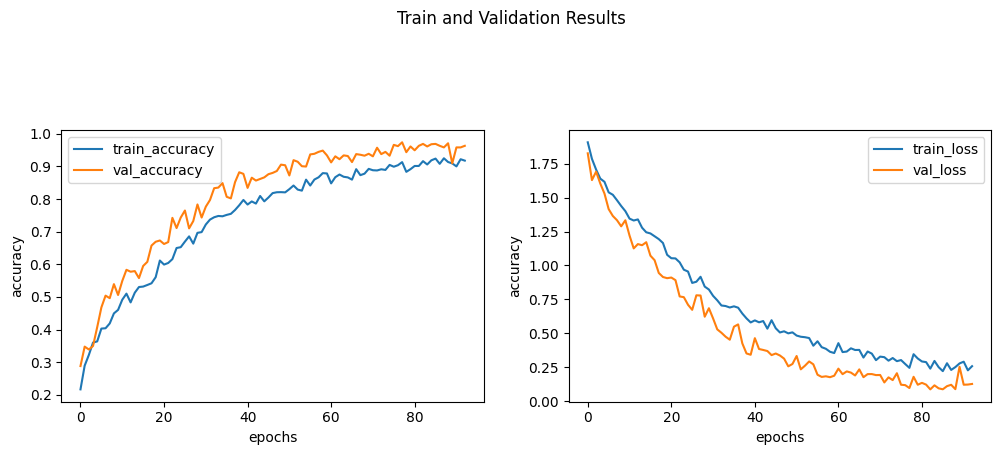

In [21]:
# Function to plot the training and validation results
def plot_results(model):
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(model.history.history['accuracy'], label = 'train_accuracy')
    plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(model.history.history['loss'], label = 'train_loss')
    plt.plot(model.history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Train and Validation Results')
    plt.legend()
    plt.show()

plot_results(model)
